# CV exercise 6 – Super-Resolution

In this exercise, we will use the ESRGAN super-resolution model to increase the resolution of an image, and we will compare its output to the results of naive interpolation.

**Note:** It is recommended to run this exercise on Google Colab with GPU acceleration enabled.

## Part 1: Data loading and preprocessing

We will use the [DIV2K](https://data.vision.ee.ethz.ch/cvl/DIV2K/) image super-resolution dataset for this problem. See the dataset webpage for more information on its contents.

**Questions:**
1. Download the contents of DIV2K ["Validation Data Track 1 bicubic downscaling x4 (LR images)"](http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip). Note: In Google Colab, it is much faster to run a code cell containing `! wget (URL)` in order to download, rather than downloading the data locally and uploading to the Google Colab runtime.
2. Unzip the archive and browse the images. Note: you may unzip the archive in Colab by running a code cell containing `! unzip (filename)`.
3. We will use the image `0812x4.png` for our tests. Using OpenCV, load this image as a NumPy array `img_hr`.
4. Convert `img_hr` to RGB format, and crop it by removing its last few rows and/or columns so that it has dimensions that are multiples of four. What is the final shape of `img_hr`?
5. Display the image `img_hr`.
6. To create the low-resolution version of our image, we will use the Pillow image processing library. We could do this with OpenCV but the Pillow bicubic downscaling method gives slightly better results. Uncomment the code below and fill in the missing values to bicubically downscale the image to a new low-resolution image `img_lr` that is 1/4 as wide and 1/4 as high as `img_hr`.
7. Display `img_lr`. How does it look compared to `img_hr`?

In [1]:
#1.
! wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip

--2024-03-29 14:16:26--  http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip
Resolving data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)... 129.132.52.178, 2001:67c:10ec:36c2::178
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip [following]
--2024-03-29 14:16:26--  https://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip
Connecting to data.vision.ee.ethz.ch (data.vision.ee.ethz.ch)|129.132.52.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31505881 (30M) [application/zip]
Saving to: ‘DIV2K_valid_LR_bicubic_X4.zip’

DIV2K_valid_LR_bicu 100%[===================>]  30.05M  16.9MB/s    in 1.8s    

2024-03-29 14:16:28 (16.9 MB/s) - ‘DIV2K_valid_LR_bicubic_X4.zip’ saved [31505881/31505881]



In [2]:
#2.
! unzip DIV2K_valid_LR_bicubic_X4.zip

Archive:  DIV2K_valid_LR_bicubic_X4.zip
   creating: DIV2K_valid_LR_bicubic/X4/
  inflating: DIV2K_valid_LR_bicubic/X4/0810x4.png  
  inflating: DIV2K_valid_LR_bicubic/X4/0866x4.png  
  inflating: DIV2K_valid_LR_bicubic/X4/0882x4.png  
  inflating: DIV2K_valid_LR_bicubic/X4/0836x4.png  
  inflating: DIV2K_valid_LR_bicubic/X4/0805x4.png  
  inflating: DIV2K_valid_LR_bicubic/X4/0881x4.png  
  inflating: DIV2K_valid_LR_bicubic/X4/0880x4.png  
  inflating: DIV2K_valid_LR_bicubic/X4/0872x4.png  
  inflating: DIV2K_valid_LR_bicubic/X4/0853x4.png  
  inflating: DIV2K_valid_LR_bicubic/X4/0862x4.png  
  inflating: DIV2K_valid_LR_bicubic/X4/0806x4.png  
  inflating: DIV2K_valid_LR_bicubic/X4/0846x4.png  
  inflating: DIV2K_valid_LR_bicubic/X4/0897x4.png  
  inflating: DIV2K_valid_LR_bicubic/X4/0812x4.png  
  inflating: DIV2K_valid_LR_bicubic/X4/0898x4.png  
  inflating: DIV2K_valid_LR_bicubic/X4/0896x4.png  
  inflating: DIV2K_valid_LR_bicubic/X4/0848x4.png  
  inflating: DIV2K_valid_LR_bicubic/

In [3]:
#3.
import cv2
img_hr = cv2.imread('DIV2K_valid_LR_bicubic/X4/0812x4.png')

In [4]:
#4.
img_hr = cv2.cvtColor(img_hr,cv2.COLOR_BGR2RGB)

In [5]:
img_hr = img_hr[:, :-2, :]

In [6]:
img_hr.shape

(384, 508, 3)

The final shape of img_hr is (384,508,3).

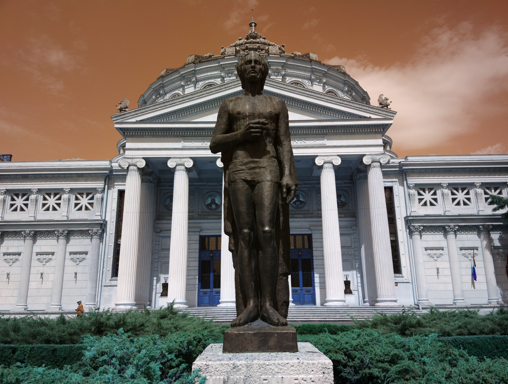

In [7]:
#5.
from google.colab.patches import cv2_imshow
cv2_imshow(img_hr)

In [8]:
### CODE FOR QUESTION 6 ###
from PIL import Image
import numpy as np

img_lr = np.asarray(
     Image.fromarray(img_hr).resize((int(img_hr.shape[1]/4),int(img_hr.shape[0]/4)) , Image.BICUBIC)
 )

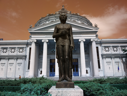

In [9]:
#7.
cv2_imshow(img_lr)

It looks much smaller than the original image.

## Loading the ESRGAN model

We will now load the ESRGAN model using the saved model available from [TensorFlow Hub](https://www.tensorflow.org/hub).

**Questions:**
8. Skim the TensorFlow Hub model documentation at  https://tfhub.dev/captain-pool/esrgan-tf2/1. What part of the ESRGAN model is available here? What does it assume about its inputs?
9. Using the code below, load the saved ESRGAN model. Note: With GPU acceleration enabled this should take about 5 seconds to load.
10. The model distributed on TF Hub is not a TF Keras model, so it does not have all of the useful Keras methods like `.summary()` available for use. However, we can examine it with the low-level TensorFlow API. Use the code below to count the number of weights in the model.
11. Create a variable `img_tensor` that contains `img_lr` converted to be a TensorFlow tensor. (Recall from the Intro to TensorFlow lecture how to convert NumPy arrays to tensors.) Make sure of the following:
  * `img_tensor` should be in BHWC format (batch-height-width-cannel) and have shape `(1, 96, 127, 3)`
  * `img_tensor` should contain data with type `tf.float32`. (Hint: use the `dtype=` parameter.)
12. Run `model(img_tensor)` to upscale the low-res image. Use the magic command `%time` to measure the time that this takes, and convert the output to a NumPy array. Save the result in a variable `output`. What is the type and shape of `output`?
13. Because the model outputs a tensor object containing floating point values, we must do some preprocessing. Perform the following steps and save the output in a variable `output_post`:
  * Convert to a NumPy array
  * Convert to HWC format (remove batch dimension)
  * Clip values to be between 0 and 255 (recommendation: use `np.clip(...)`)
  * Convert values in `output_post` to data type `np.uint8` (recommendation: use `.astype(...)`). Note: Later steps will not work if you use the regular Python `int` data type.

8. The generator model is available here. It assumes that the inputs dimension is 4.

In [10]:
### CODE FOR QUESTION 9 ###
import tensorflow_hub as hub

SAVED_MODEL_PATH = 'https://tfhub.dev/captain-pool/esrgan-tf2/1'
%time model = hub.load(SAVED_MODEL_PATH)

CPU times: user 7.72 s, sys: 433 ms, total: 8.15 s
Wall time: 15.3 s


In [11]:
### CODE FOR QUESTION 10 ###
np.sum([np.prod(v.get_shape().as_list()) for v in model.variables])

4605955

In [12]:
#11.
import tensorflow as tf
img_tensor = tf.constant(img_lr, dtype=tf.float32)

In [13]:
img_tensor = tf.reshape(img_tensor, (1, 96, 127, 3))

In [14]:
#12.
%time output = model(img_tensor)

CPU times: user 4.92 s, sys: 192 ms, total: 5.11 s
Wall time: 3.91 s


In [15]:
output = output.numpy()

In [16]:
output.shape

(1, 384, 508, 3)

The shape of output is (1, 384, 508, 3).

In [17]:
type(output)

numpy.ndarray

The type of output is ndarray.

In [18]:
#13.
import numpy as np
output_post = np.squeeze(output,axis = 0)
output_post = np.clip(output_post,0,255)
output_post = output_post.astype(np.uint8)

## Evaluating results

We will now examine the output of ESRGAN and compare it to naive interpolation upscaling algorithms.

**Questions:**
14. Using OpenCV, use bilinear and bicubic interpolation to scale `img_lr` to be four times as large in both dimensions. Store the resulting images in variables `img_bilinear` and `img_bicubic`. Make sure that `output_post`, `img_bilinear`, and `img_bicubic` all have the same shape.
15. Using `cv2.PSNR(...)`, calculate PSNR values for all three upscaled images relative to the original image `img_hr`.
16. Using `plt.subplots(1, 3, figsize=(20, 20))`, show all three upscaled images side-by-side. Each image should have a title displayed containing its upscaling algorithm name (bilinear/bicubic/ESNR) and its PSNR value. Round the PSNR values to 2 decimal points to the titles are easy to read.
17. Which image has the best PSNR value? Does this make sense?
18. Try running all of these steps (running ESRGAN and comparing its output to naive interpolation) on another image from the DIV2K dataset, save the final subplot comparing the different upscaled images, and upload it to the class Slack channel.

**Final note:** You may also try running ESRGAN on your own images from other sources, but it may be sensitive to the size of the input image or the presence of [artifacts](https://en.wikipedia.org/wiki/Visual_artifact) in the image due to reasons such as compression (e.g. jpeg images).

In [19]:
output_post.shape

(384, 508, 3)

In [20]:
img_lr.shape

(96, 127, 3)

In [21]:
#14.
img_bilinear = cv2.resize(img_lr,(img_lr.shape[1]*4, img_lr.shape[0]*4), interpolation = cv2.INTER_LINEAR)

In [22]:
img_bicubic = cv2.resize(img_lr,(img_lr.shape[1]*4, img_lr.shape[0]*4), interpolation = cv2.INTER_CUBIC)

In [23]:
output_post.shape, img_bilinear.shape, img_bicubic.shape

((384, 508, 3), (384, 508, 3), (384, 508, 3))

In [24]:
#15.
psnr_op = cv2.PSNR(output_post,img_hr)
psnr_bil = cv2.PSNR(img_bilinear, img_hr)
psnr_bic = cv2.PSNR(img_bicubic, img_hr)

In [25]:
psnr_op, psnr_bil, psnr_bic

(23.681307205932654, 22.313313757543742, 22.85652050123123)

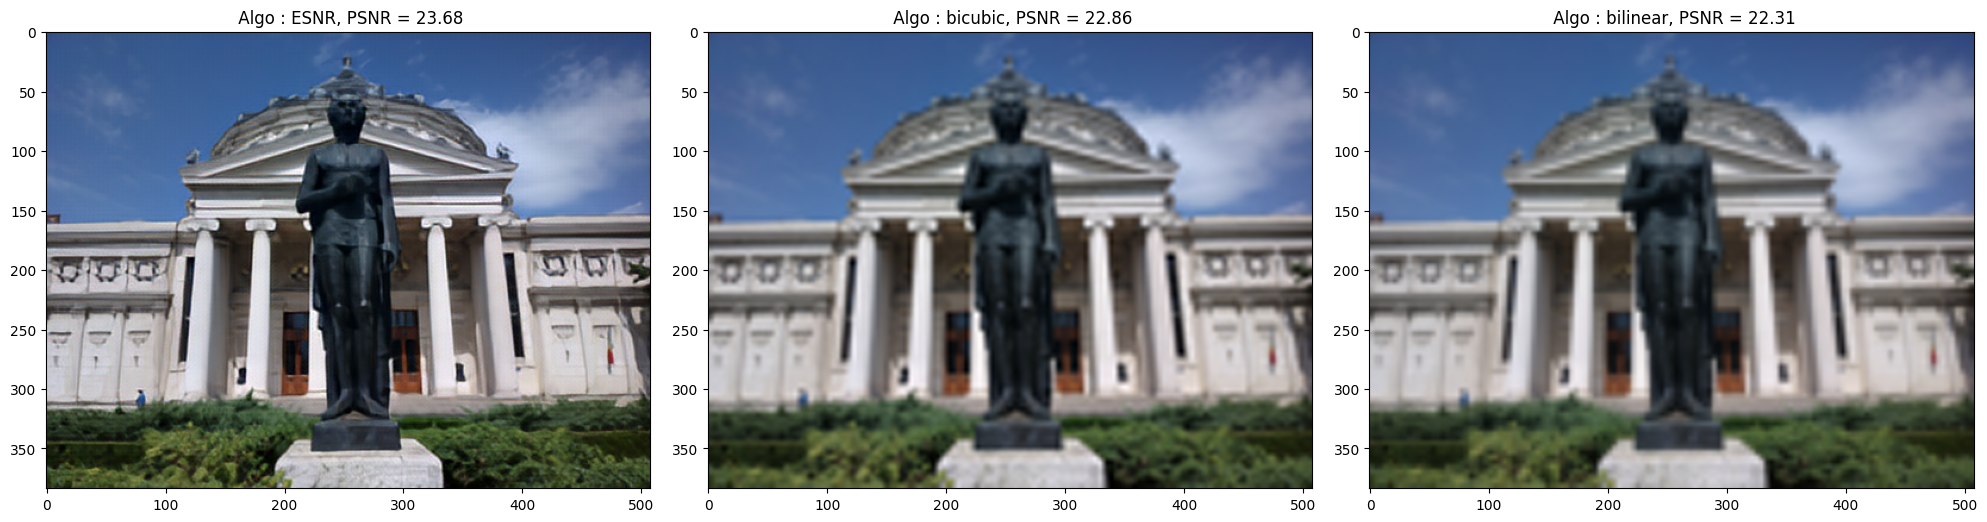

In [26]:
#16.
import matplotlib.pyplot as plt
f,axes = plt.subplots(1,3,figsize = (20,20))
imgs = [output_post,img_bicubic,img_bilinear]
psnrs = [psnr_op,psnr_bic, psnr_bil]
algo = ['ESNR','bicubic','bilinear']
for index,img in enumerate(imgs):
  axes[index].imshow(img)
  axes[index].set_title(f' Algo : {algo[index]}, PSNR = {round(psnrs[index],2)}')

plt.tight_layout()
plt.show()



17. The image from the ESNR algo has the best PSNR. It makes sense as it uses the most elaborated algorithm.

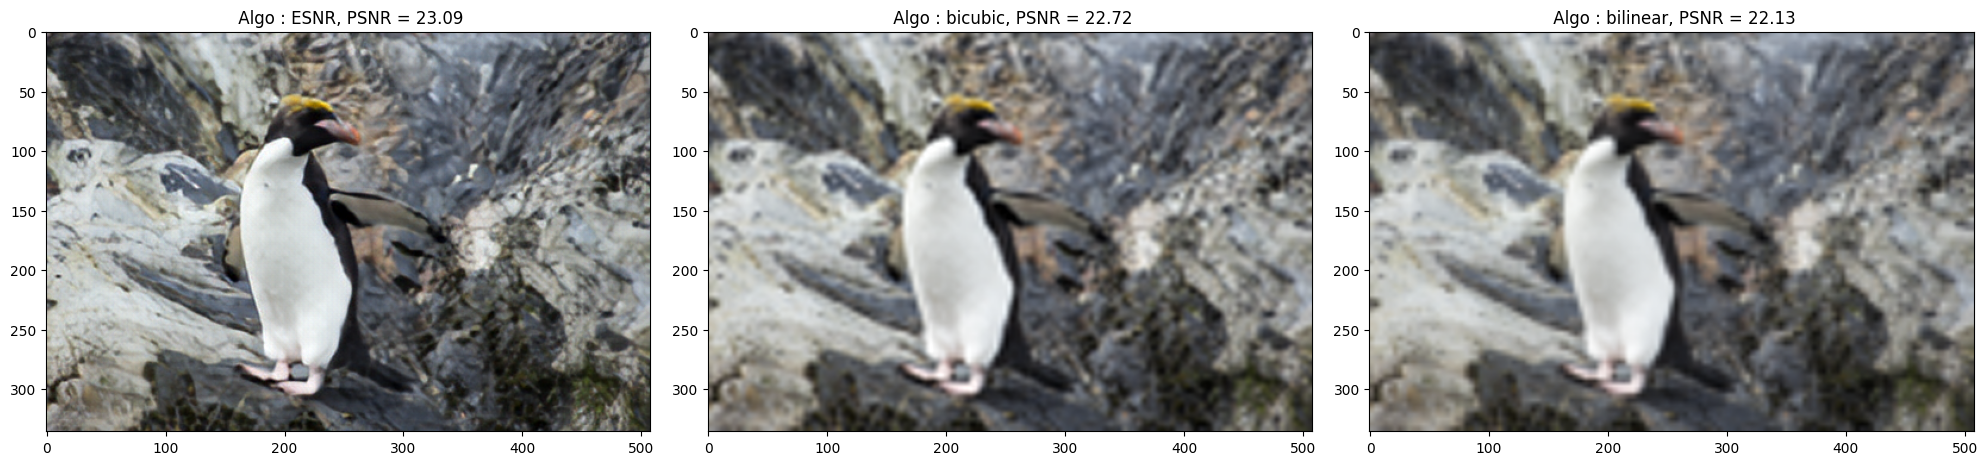

In [27]:
#18.
img_hr_bis = cv2.imread('DIV2K_valid_LR_bicubic/X4/0801x4.png')
img_hr_bis = cv2.cvtColor(img_hr_bis,cv2.COLOR_BGR2RGB)
img_hr_bis = img_hr_bis[:-3, :-2, :]
img_lr_bis = np.asarray(
     Image.fromarray(img_hr_bis).resize((int(img_hr_bis.shape[1]/4),int(img_hr_bis.shape[0]/4)) , Image.BICUBIC)
 )
img_tensor_bis = tf.constant(img_lr_bis, dtype=tf.float32)
img_tensor_bis = tf.reshape(img_tensor_bis, (1, 84, 127, 3))
output = model(img_tensor_bis)
output = output.numpy()
output_post = np.squeeze(output,axis = 0)
output_post = np.clip(output_post,0,255)
output_post = output_post.astype(np.uint8)
img_bilinear = cv2.resize(img_lr_bis,(img_lr_bis.shape[1]*4, img_lr_bis.shape[0]*4), interpolation = cv2.INTER_LINEAR)
img_bicubic = cv2.resize(img_lr_bis,(img_lr_bis.shape[1]*4, img_lr_bis.shape[0]*4), interpolation = cv2.INTER_CUBIC)
psnr_op = cv2.PSNR(output_post,img_hr_bis)
psnr_bil = cv2.PSNR(img_bilinear, img_hr_bis)
psnr_bic = cv2.PSNR(img_bicubic, img_hr_bis)

f,axes = plt.subplots(1,3,figsize = (20,20))
imgs = [output_post,img_bicubic,img_bilinear]
psnrs = [psnr_op,psnr_bic, psnr_bil]
algo = ['ESNR','bicubic','bilinear']
for index,img in enumerate(imgs):
  axes[index].imshow(img)
  axes[index].set_title(f' Algo : {algo[index]}, PSNR = {round(psnrs[index],2)}')

plt.tight_layout()
plt.show()
